# Projeto: Classificação de Defeitos em Chapas de Aço Inoxidável

Este notebook realiza:
- Pré-processamento de dados
- Balanceamento com SMOTE
- Modelagem com RandomForest e XGBoost
- Otimização com GridSearchCV
- Validação cruzada
- Salvamento do modelo final

## 1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib


## 2. Funções Auxiliares

In [2]:
def convert_to_binary(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.strip().lower()
        if value in ['true', '1', 't', 'sim', 'yes']:
            return 1
        elif value in ['false', '0', 'f', 'não', 'no']:
            return 0
        return np.nan
    return int(bool(value))


## 3. Carregamento e Preparação dos Dados

In [3]:
df = pd.read_csv("bootcamp_train.csv")

binary_cols = ['tipo_do_aço_A300', 'tipo_do_aço_A400']
falhas = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']

for col in binary_cols + falhas:
    df[col] = df[col].apply(convert_to_binary)

df[binary_cols + falhas] = SimpleImputer(strategy='most_frequent').fit_transform(df[binary_cols + falhas])

df = df[df[falhas].sum(axis=1) == 1].copy()
df['classe'] = df[falhas].idxmax(axis=1)
df.drop(columns=falhas, inplace=True)

le = LabelEncoder()
df['classe'] = le.fit_transform(df['classe'])

X = df.drop(columns=['id', 'classe'])
y = df['classe']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocess_pipeline = SklearnPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


## 4. Análise Exploratória

<ipython-input-4-b9f5b4ca65d4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y), palette='viridis')


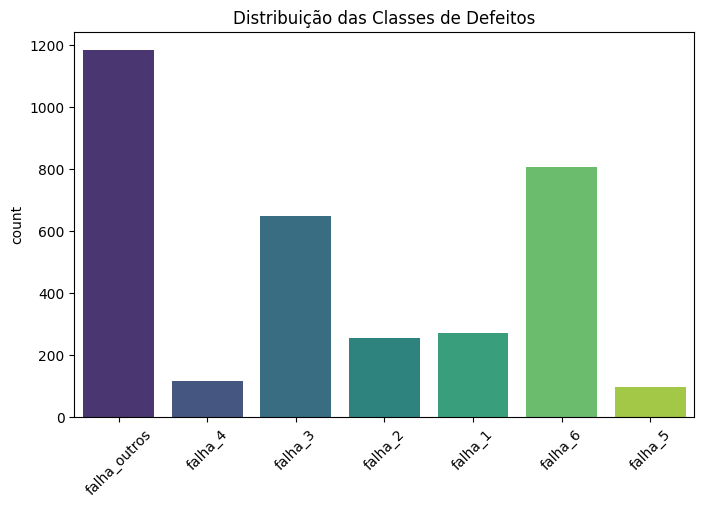

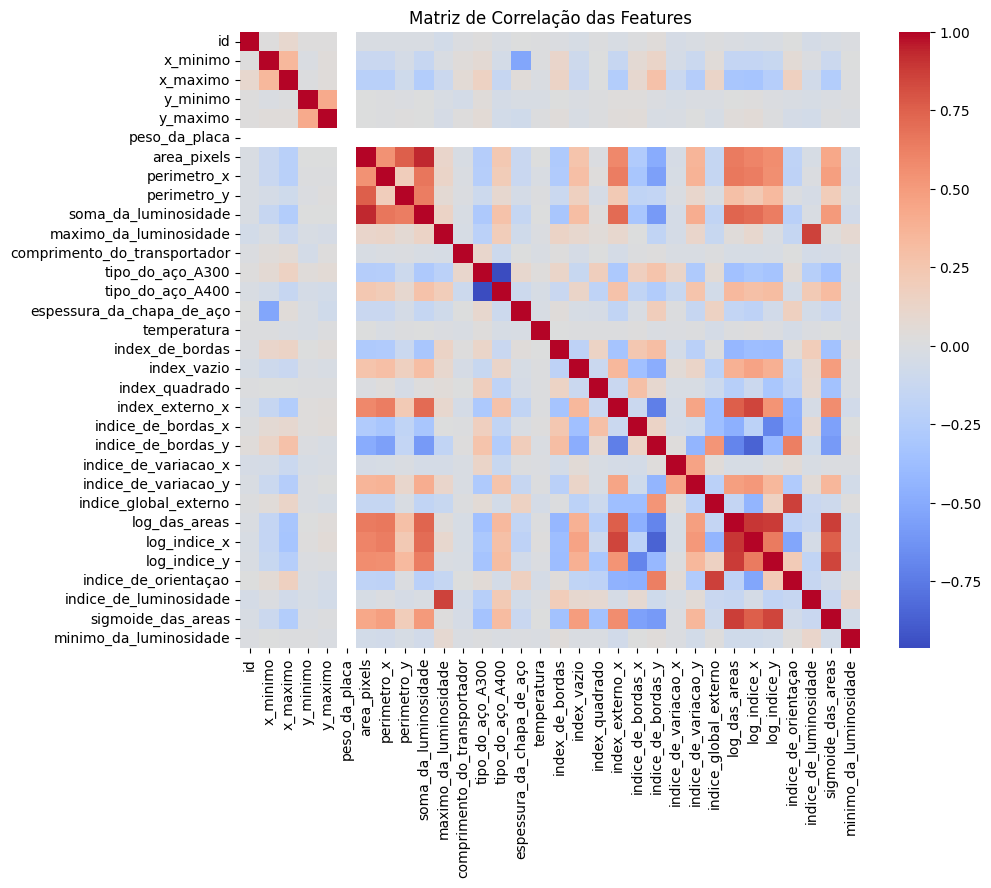

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(x=le.inverse_transform(y), palette='viridis')
plt.title("Distribuição das Classes de Defeitos")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns='classe').corr(), cmap='coolwarm', annot=False)
plt.title("Matriz de Correlação das Features")
plt.show()


In [5]:
plt.savefig("Distribuição das Classes de Defeitos.png", bbox_inches='tight', dpi=300)


<Figure size 640x480 with 0 Axes>

In [6]:
plt.savefig("Matriz de Correlação das Features.png", bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

## 5. Definição de Pipeline e Modelos

In [7]:
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])


## 6. Tuning de Hiperparâmetros - Random Forest

In [8]:
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__class_weight': ['balanced']
}

grid_rf = GridSearchCV(pipeline, param_grid_rf, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Melhores parâmetros RF:", grid_rf.best_params_)
print("Melhor F1 RF:", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Melhores parâmetros RF: {'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__n_estimators': 100}
Melhor F1 RF: 0.6631858081791602


## 7. Tuning de Hiperparâmetros - XGBoost

In [9]:
pipeline.set_params(clf=XGBClassifier(eval_metric='mlogloss', random_state=42))

param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(pipeline, param_grid_xgb, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Melhores parâmetros XGB:", grid_xgb.best_params_)
print("Melhor F1 XGB:", grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Melhores parâmetros XGB: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200}
Melhor F1 XGB: 0.6734782718775033


## 8. Escolha e Salvamento do Modelo Final

In [10]:
final_model = best_xgb if grid_xgb.best_score_ > grid_rf.best_score_ else best_rf
final_model.fit(X_train, y_train)

joblib.dump(final_model, 'modelo_otimizado.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Modelo final salvo com sucesso!")


Modelo final salvo com sucesso!


## 9. Avaliação com Matriz de Confusão

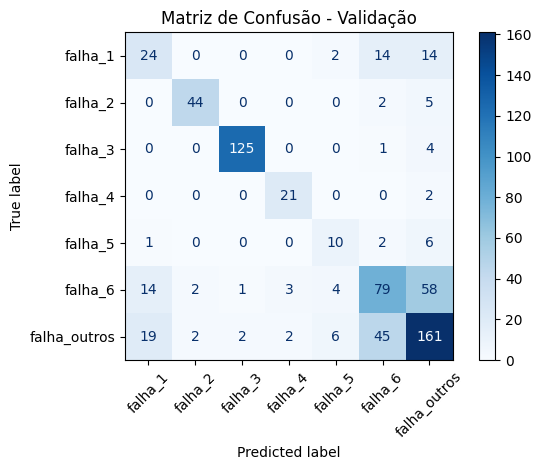

In [11]:
y_pred = final_model.predict(X_val)

ConfusionMatrixDisplay.from_estimator(
    final_model, X_val, y_val,
    display_labels=le.classes_,
    cmap='Blues'
)
plt.title("Matriz de Confusão - Validação")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


## 10. Interpretação - Importância das Features

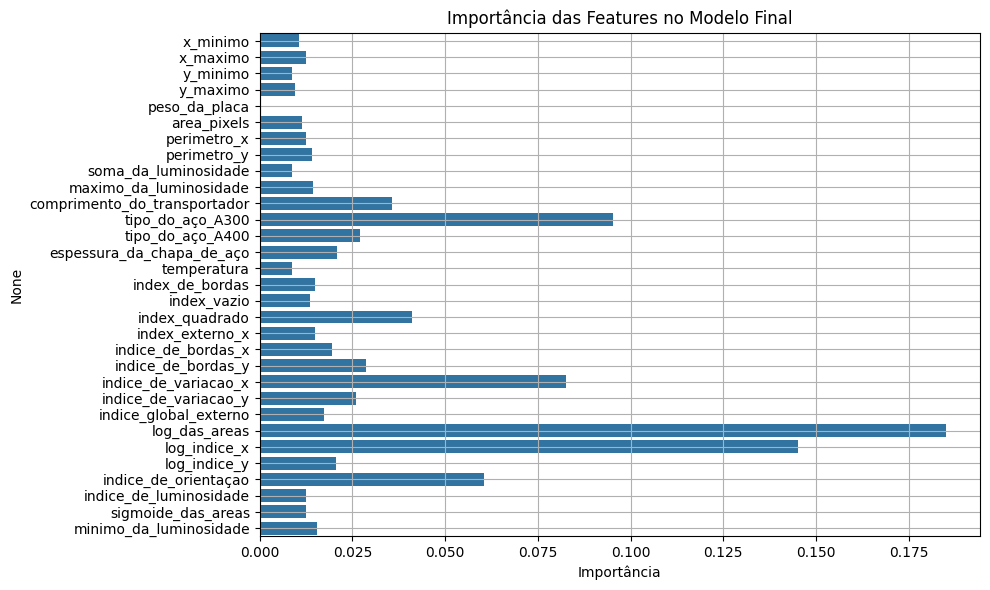

In [12]:
importances = final_model.named_steps['clf'].feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Importância das Features no Modelo Final")
plt.xlabel("Importância")
plt.tight_layout()
plt.grid(True)
plt.show()


## 11. Visualização PCA 2D

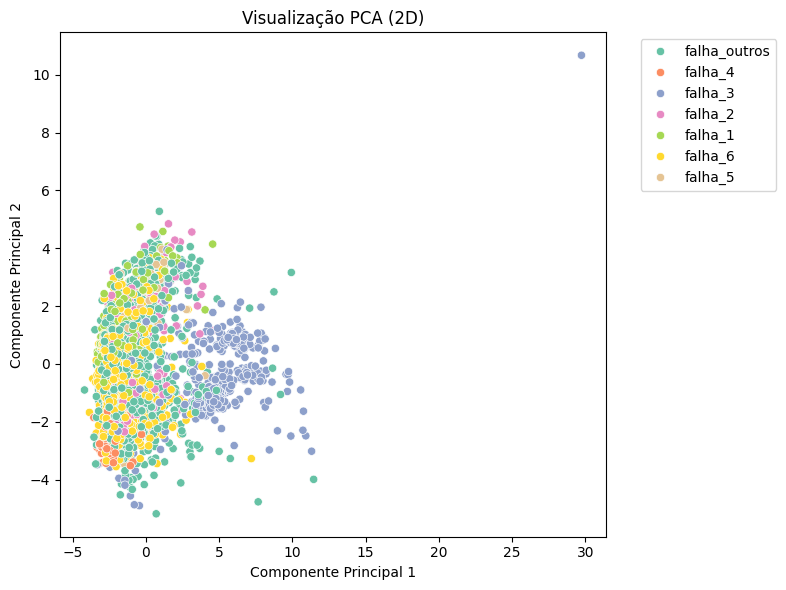

In [13]:
X_transformed = preprocess_pipeline.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=le.inverse_transform(y), palette='Set2')
plt.title("Visualização PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 12. Validação Cruzada

In [14]:
f1_rf = cross_val_score(best_rf, X, y, scoring='f1_macro', cv=5)
f1_xgb = cross_val_score(best_xgb, X, y, scoring='f1_macro', cv=5)

print("F1-macro RF:", f1_rf)
print("Média F1 RF:", f1_rf.mean())
print("F1-macro XGB:", f1_xgb)
print("Média F1 XGB:", f1_xgb.mean())


F1-macro RF: [0.75730576 0.74503039 0.64924621 0.5850314  0.58543682]
Média F1 RF: 0.6644101171803473
F1-macro XGB: [0.76143949 0.76190175 0.66997007 0.61067582 0.56555093]
Média F1 XGB: 0.6739076108904749


## 13. Curva de Aprendizado

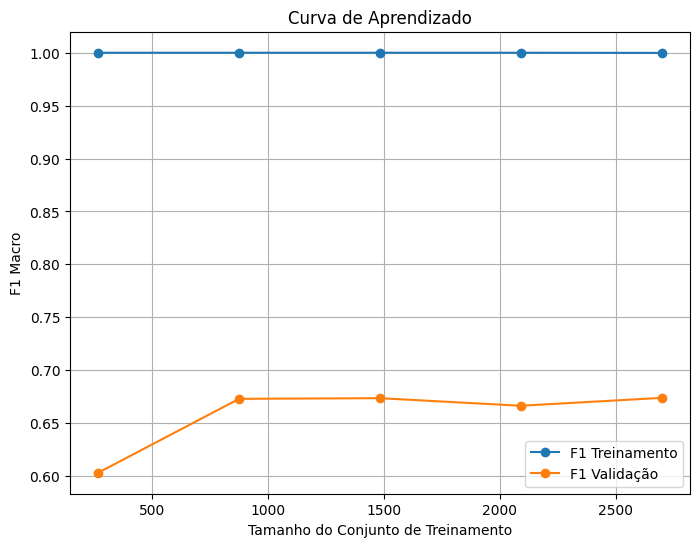

In [15]:
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=5, scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='F1 Treinamento')
plt.plot(train_sizes, val_mean, 'o-', label='F1 Validação')
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid(True)
plt.show()


## 14. identificação de overfitting


In [17]:
f1_train = f1_score(y_train, final_model.predict(X_train), average='macro')
f1_val = f1_score(y_val, y_pred, average='macro')
print(f"F1 Treino: {f1_train:.4f} | F1 Validação: {f1_val:.4f}")


F1 Treino: 1.0000 | F1 Validação: 0.6875


## 15. Avaliação ROC-AUC por Classe

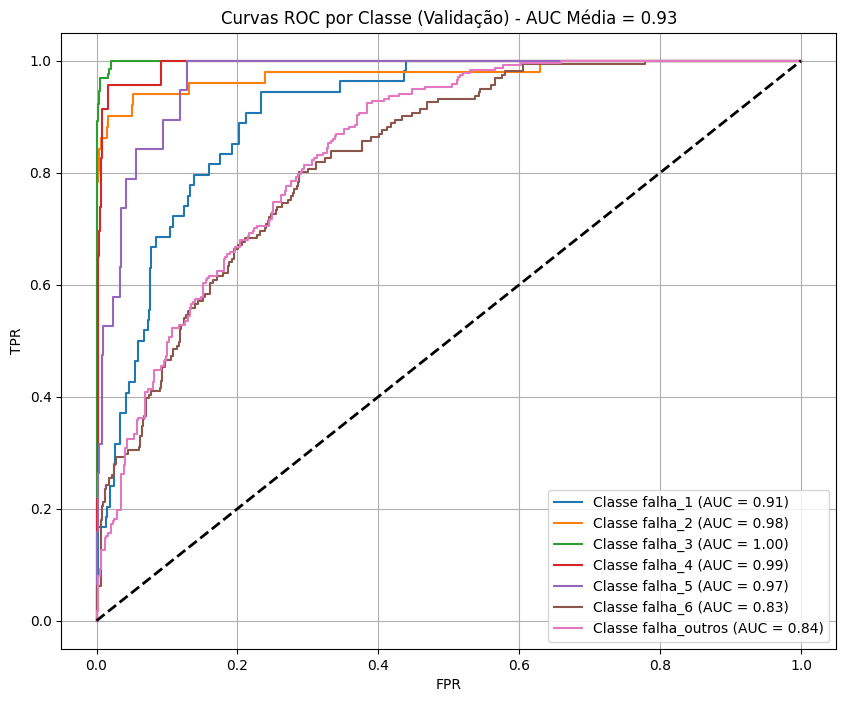

<ipython-input-16-09745f2efd75>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[le.inverse_transform([i])[0] for i in range(n_classes)],


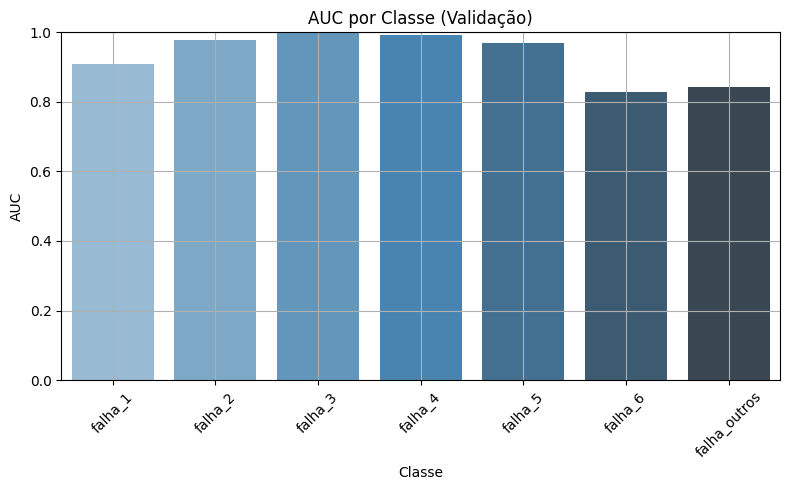

In [16]:
y_val_bin = label_binarize(y_val, classes=np.unique(y))
n_classes = y_val_bin.shape[1]
y_val_score = final_model.predict_proba(X_val)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc_macro = roc_auc_score(y_val_bin, y_val_score, average='macro')

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title(f'Curvas ROC por Classe (Validação) - AUC Média = {roc_auc_macro:.2f}')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=[le.inverse_transform([i])[0] for i in range(n_classes)],
            y=[roc_auc[i] for i in range(n_classes)],
            palette="Blues_d")
plt.title("AUC por Classe (Validação)")
plt.ylabel("AUC")
plt.xlabel("Classe")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## 16. Dashboard (tentando criar dashboard em pythonn)

In [12]:
import pandas as pd
import joblib

# Carregar modelo e label encoder
modelo = joblib.load('modelo_otimizado.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Carregar features das imagens reais
df_test = pd.read_csv('bootcamp_test.csv')

# Remover colunas que não são features (como 'id')
features_test = df_test.drop(columns=['id'])

# Fazer previsões
y_pred = modelo.predict(features_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Obter probabilidades
y_proba = modelo.predict_proba(features_test).max(axis=1)

# Adicionar resultados ao DataFrame original "incluindo o id"
df_test['classe_predita'] = y_pred_labels
df_test['confianca'] = y_proba

# Salvar resultados
df_test.to_csv('resultados_predicoes.csv', index=False)

In [13]:
!pip install --upgrade plotly

In [14]:
# Configuração inicial obrigatória
from google.colab import output
output.enable_custom_widget_manager()

!pip install plotly ipywidgets pandas matplotlib --quiet
!jupyter nbextension enable --py widgetsnbextension --quiet

usage: jupyter-nbextension [-h] [--debug] [--show-config] [--show-config-json]
                           [--user] [--system] [--sys-prefix] [--py]
                           [--python] [--section EnableNBExtensionApp.section]
                           [extra_args ...]
jupyter-nbextension: error: argument --quiet: expected one argument


In [15]:
from google.colab import output
output.enable_custom_widget_manager()

import plotly.io as pio
pio.renderers.default = 'colab'

In [16]:
!sudo apt-get install xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
from pyvirtualdisplay import Display
Display().start()

In [17]:
# -*- coding: utf-8 -*-
# 1. CONFIGURAÇÃO INICIAL
from google.colab import output
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Configuração de estilo
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 2. CARREGAMENTO DE DADOS
def load_data():
    try:
        df = pd.read_csv('resultados_predicoes.csv')
        print("✅ Dados carregados do arquivo CSV")
    except Exception as e:
        print(f"⚠️ Erro ao carregar dados: {str(e)}. Criando dados de exemplo...")
        np.random.seed(42)
        classes = ['normal', 'falha_1', 'falha_2', 'falha_3']
        df = pd.DataFrame({
            'id': range(100),
            'classe_predita': np.random.choice(classes, 100, p=[0.6, 0.2, 0.15, 0.05]),
            'confianca': np.clip(np.random.normal(0.85, 0.1, 100), 0.6, 1.0)
        })
    return df

df_results = load_data()
all_classes = ['Todas'] + sorted(df_results['classe_predita'].unique().tolist())

# 3. FUNÇÃO DE VISUALIZAÇÃO
def show_plots(selected_class='Todas'):
    if selected_class == 'Todas':
        df_filtered = df_results
        title_suffix = ""
    else:
        df_filtered = df_results[df_results['classe_predita'] == selected_class]
        title_suffix = f" - {selected_class}"

    # Criação de subplots em grade
    plt.close('all')
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Análise Visual das Predições{title_suffix}', fontsize=16)

    # Gráfico 1: Pie Chart
    class_counts = df_filtered['classe_predita'].value_counts()
    axes[0, 0].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
                   startangle=90, colors=plt.cm.Pastel1.colors)
    axes[0, 0].set_title('Distribuição de Classes')
    axes[0, 0].axis('equal')

    # Gráfico 2: Boxplot da confiança
    if selected_class == 'Todas':
        sns.boxplot(x='classe_predita', y='confianca', data=df_filtered, ax=axes[0, 1])
    else:
        axes[0, 1].boxplot(df_filtered['confianca'])
        axes[0, 1].set_xticklabels([selected_class])
    axes[0, 1].set_title('Níveis de Confiança')
    axes[0, 1].set_xlabel('Classe')
    axes[0, 1].set_ylabel('Confiança')

    # Gráfico 3: Frequência (Bar chart)
    df_filtered['classe_predita'].value_counts().plot(kind='bar', ax=axes[0, 2])
    axes[0, 2].set_title('Frequência de Classes')
    axes[0, 2].set_ylabel('Contagem')

    # Gráfico 4: Histograma de confiança
    axes[1, 0].hist(df_filtered['confianca'], bins=10, color='skyblue', edgecolor='black')
    axes[1, 0].set_title('Histograma da Confiança')
    axes[1, 0].set_xlabel('Confiança')
    axes[1, 0].set_ylabel('Frequência')

    # Gráfico 5: Linha cumulativa (opcional)
    df_sorted = df_filtered.sort_values('confianca')
    axes[1, 1].plot(df_sorted['confianca'].values, marker='o', linestyle='-')
    axes[1, 1].set_title('Confiança Ordenada')
    axes[1, 1].set_xlabel('Amostra')
    axes[1, 1].set_ylabel('Confiança')

    # Gráfico 6: Espaço reservado
    axes[1, 2].axis('off')
    axes[1, 2].text(0.5, 0.5, 'Espaço disponível\npara outro gráfico',
                   ha='center', va='center', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Estatísticas
    print(f"\n📊 Estatísticas para: {selected_class if selected_class != 'Todas' else 'Todas as classes'}")
    print(f"• Total de amostras: {len(df_filtered)}")
    print(f"• Confiança média: {df_filtered['confianca'].mean():.1%}")
    print(f"• Classes disponíveis: {', '.join(df_results['classe_predita'].unique())}")

# 4. INTERFACE INTERATIVA COM DROPDOWN
dropdown = widgets.Dropdown(
    options=all_classes,
    value='Todas',
    description='Classe:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

button = widgets.Button(
    description="Gerar Visualização",
    button_style='success',
    icon='bar-chart'
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        show_plots(dropdown.value)

button.on_click(on_button_click)

# Exibir interface
display(widgets.VBox([dropdown, button, output_area]))


✅ Dados carregados do arquivo CSV
